In [1]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import pickle
import os
import pandas as pd
import numpy as np
from soundsig.sound import BioSound, plot_spectrogram
from soundsig.sound import WavFile
from soundsig import sound


# Dimension reduction and clustering libraries
# import zscore
from scipy.stats import zscore
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.decomposition import PCA



# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt



def print_missing_features(X, XFeatureNames, indBad):
    missing_features = list()
    for feature in XFeatureNames:
        num_missing=0
        for i in indBad: 
            if np.isnan(X[i,np.where(XFeatureNames == feature)[0][0]]):
                num_missing += 1
        if num_missing > 0: print(f'num missing {feature} = {num_missing}')

In [2]:
base_folder = "/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023"# _Maeves_data"
h5_folder = 'h5filesAmp'

fs = 48000 # TODO find where to import fs instead of hardcoding it

os.chdir(os.path.join(base_folder, h5_folder))
print(os.getcwd())
files_list = os.listdir('.')
print(f'num files = {len(files_list)}, files_list[0] = {files_list[0]}')

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/h5filesAmp
num files = 4345, files_list[0] = bird_WhiWhi6607F_call_["0"]_1134.h5


In [3]:
# Testing with one file
fname = files_list[1]

myBioSound = BioSound()
myBioSound.readh5(fname)
        
# Take the time average formants 
meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
        
# These are our two identifier - the emitter (bird) and the call type
Bird = np.array2string(myBioSound.emitter)[2:-1]
callType = np.array2string(myBioSound.type)[2:-1]

print("The following values shouldn't be NaN or 0")
print(f'meanF1 = {meanF1}, meanF2 = {meanF2}, meanF3 = {meanF3}, Bird = {Bird}, callType = {callType}')

The following values shouldn't be NaN or 0
meanF1 = 1223.1475918116207, meanF2 = 4405.922739456839, meanF3 = 9015.34493500762, Bird = BluGre1214F, callType = ["6"]


In [4]:
# # vocSelData is going to be a list of dictionary containing the values that we are going to extract from each BioSound object.
# vocSelData = []

# # Looping through all the files
# i = 0
# for fname in files_list:
#     if fname.endswith('.h5'):
#         # print(f'index = {i}, fname = {fname}')
#         # print(fname)
#         # Allocate object and read data
#         myBioSound = BioSound()
#         try:
#             myBioSound.readh5(fname)
#         except:
#             print('Could not read h5 file', fname)
#             continue
        
#         # These are our two identifier - the emitter (bird) and the call type
#         Bird = np.array2string(myBioSound.emitter)[2:-1]
#         callType = np.array2string(myBioSound.type)[2:-1]

#         # Get values for the fundamental
#         if myBioSound.fund.size > 0:
#             fund = float(myBioSound.fund)
#             cvfund = float(myBioSound.cvfund)
#             maxfund = float(myBioSound.maxfund)
#             minfund = float(myBioSound.minfund)
#             devfund = np.nanmean(np.diff(myBioSound.f0))
#                     # Take the time average formants 
#             meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
#             meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
#             meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
#         else:
#             fund = -10 
#             cvfund = 0   
#             maxfund = 0
#             # TODO add default value of devfund
#             # TODO just notes here: play with UMAP neighborhood.
#             # TODO play with HDBScan neighborhood. fit it. silhouette score. davis dun score. 
#             # TODO # of unclassified calls.
#             # TODO try to classifiy noise vs calls. force 2 clusters.
#             # then look at soundsep. 
#             minfund = 0
#             devfund = 0
#             meanF1 = 0
#             meanF2 = 0
#             meanF3 = 0
            

#         vocSelData.append({"Bird": Bird, 
#                      "project.start_index": int(fname.split('.')[0].split('_')[-1]),
#                      "calltype": callType, 
#                      "fund": fund, "devfund": devfund,
#                      "cvfund": cvfund, "maxfund": maxfund, "minfund": minfund,
#                      "F1": meanF1, "F2": meanF2, "F3":meanF3,
#                      "sal": float(myBioSound.meansal), 
#                      "rms": float(myBioSound.rms), 
#                      "maxAmp": float(myBioSound.maxAmp),
#                      "meanS": float(myBioSound.meanspect), "stdS": float(myBioSound.stdspect),
#                      "skewS": float(myBioSound.skewspect), "kurtS": float(myBioSound.kurtosisspect), 
#                      "entS": float(myBioSound.entropyspect),
#                      "q1": float(myBioSound.q1), "q2": float(myBioSound.q2), "q3": float(myBioSound.q3),                  
#                      "meanT": float(myBioSound.meantime), "stdT": float(myBioSound.stdtime),
#                      "skewT": float(myBioSound.skewtime), "kurtT": float(myBioSound.kurtosistime),
#                      "entT": float(myBioSound.entropytime)
        
# })
#         i += 1
#         if ((i % 1000) == 0):
#             print('Done with', i, 'files')
#         #if (i == 10000):
#             #break

# print(f'Done with {i} files')

In [5]:
# Write the results to a pandas df

# tableStore = os.path.join(base_folder,'vocSelTableAmp.h5')
# vocSelTable = pd.DataFrame(vocSelData)
# vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')

In [6]:
# You can also start the script here and skip the reading of h5 files and creation of table
# Read the vocSelTable
vocSelTable = pd.read_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5')) # 
print(f"loading file: {os.path.join(base_folder, 'vocSelTableAmp.h5')} with {len(vocSelTable)} syllables")

loading file: /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/vocSelTableAmp.h5 with 4344 syllables


In [7]:
# Read the annotated syllabes.csv (soundsep metadata) to get information on solo vs overlap and what tags were manually entered
syll_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
# backup_name = os.path.join(base_folder,'_appdata','save','segments_backup_good.csv')
syllTable = pd.read_csv(syll_file_name, sep=',',header=0) 
print(f"loading {syll_file_name} with {len(syllTable)} syllables")

birds = np.unique(vocSelTable['Bird'])
print(f'birds = {birds}')

loading /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv with 4344 syllables
birds = ['BluGre1214F' 'BroGre1354M' 'WhiWhi1541M' 'WhiWhi6607F']


In [8]:
print(vocSelTable.columns)
print(syllTable.columns)
print(vocSelTable['project.start_index'])
print(syllTable["Unnamed: 0"])

Index(['Bird', 'project.start_index', 'calltype', 'fund', 'devfund', 'cvfund',
       'maxfund', 'minfund', 'F1', 'F2', 'F3', 'sal', 'rms', 'maxAmp', 'meanS',
       'stdS', 'skewS', 'kurtS', 'entS', 'q1', 'q2', 'q3', 'meanT', 'stdT',
       'skewT', 'kurtT', 'entT'],
      dtype='object')
Index(['Unnamed: 0', 'SourceName', 'SourceChannel', 'StartIndex', 'StopIndex',
       'Tags', 'cluster', 'coords'],
      dtype='object')
0       1134
1        951
2       3202
3       2406
4        311
        ... 
4339     264
4340    2596
4341    2607
4342     453
4343    2144
Name: project.start_index, Length: 4344, dtype: int64
0          0
1          1
2          2
3          3
4          4
        ... 
4339    4339
4340    4340
4341    4341
4342    4342
4343    4343
Name: Unnamed: 0, Length: 4344, dtype: int64


In [9]:
# This isn't necessary unless I'm going to pull spectrograms, but I probably will... 

# # now load h5_indices
h5_indices = pickle.load(open(os.path.join(base_folder,'spec_results','h5_inds.pkl'),'rb'))
# print(h5_indices)
# h5_indices = np.asarray(h5_indices)
# # np.where(h5_indices==216)[0][0]
# df['SpecInd'] = None
# for ix, df_ind in enumerate(h5_indices):
#     if df_ind in df.index:
#         df.loc[df_ind,'SpecInd'] = ix


In [10]:
# Now we merge the syllTable (soundsep metadata) and the vocSelTable (biosound features).TextDisplayObject
# The indices ARE NOT THE SAME, so we can't just merge the tables on the index
# the index of vocSelTable is 'project.start_index' column
# and the index of syllTable is the index
# so we need to sort vocSelTable by 'project.start_index' column
# then make the index of vocSelTable the 'project.start_index' column
# then merge the two tables on the index

# might as well check if the indices are the same while I'm at it
if np.array_equal(vocSelTable.index, syllTable.index):
    # sort vocSelTable by 'project.start_index' column
    vocSelTable = vocSelTable.sort_values(by='project.start_index')

    # make the index of vocSelTable the 'project.start_index' column
    vocSelTable.index = vocSelTable['project.start_index'].values
    # # drop the 'project.start_index' column
    vocSelTable = vocSelTable.drop(columns=['project.start_index'])
    vocSelTableFull = pd.merge(vocSelTable, syllTable, left_index=True, right_index=True)

    # also sort the files_list by 'project.start_index' column
    files_list = [[f, int(f.split('.')[0].split('_')[-1])] for f in files_list if f.endswith('.h5')]
    files_list = pd.DataFrame(files_list, columns=['file', 'project.start_index'])
    files_list = files_list.sort_values(by='project.start_index')
    files_list.index = files_list['project.start_index'].values
    files_list = files_list['file']

else:
    print('The indices are not the same this is a problem, a big problem')
# vocSelTableFull

In [11]:
# print(vocSelTableFull.columns)
# print(vocSelTableFull['project.start_index'])
# print(vocSelTableFull.index)

['["8"]' '["tet"]' '["hat"]' '["2"]' '["call"]' '["3"]' '["WF"]' '["DC"]'
 '["-2"]']
['8' 'tet' 'hat' '2' 'call' '3' 'WF' 'DC' '-2']


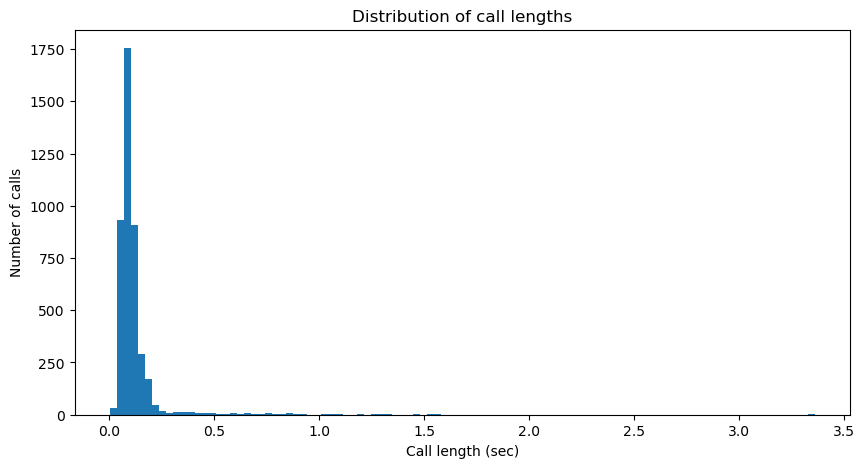

In [12]:
# calculate the length of each call
vocSelTableFull['callLength'] = (vocSelTableFull['StopIndex'] - vocSelTableFull['StartIndex']) / fs
 
# plot the distribution of call lengths
plt.figure(figsize=(10, 5))
plt.hist(vocSelTableFull['callLength'], bins=100)
plt.xlabel('Call length (sec)')
plt.ylabel('Number of calls')
plt.title('Distribution of call lengths')

# The tags have extra characters that I don't want
print(vocSelTableFull['Tags'].unique())
# it appears they have a '[""]' surrounding them
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')
print(vocSelTableFull['Tags'].unique())
# change the tags column of the df to the stripped version
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')

In [13]:
# Generate the data array of biosound features
# X is the data array of features.
startFeat = 2
endFeat = 9
startFeat2 = 10
endFeat2 = 26
# note I added callLength to the features, which is the last one
# salInd = 6 # saliency index, I don't think this is good to exclude by
XFeatureNames = np.array(np.hstack((vocSelTableFull.columns[startFeat:endFeat],vocSelTableFull.columns[startFeat2:endFeat2],vocSelTableFull.columns[-1:])))
print('Features chosen:', XFeatureNames)
nfeatures = len(XFeatureNames)

Features chosen: ['fund' 'devfund' 'cvfund' 'maxfund' 'minfund' 'F1' 'F2' 'sal' 'rms'
 'maxAmp' 'meanS' 'stdS' 'skewS' 'kurtS' 'entS' 'q1' 'q2' 'q3' 'meanT'
 'stdT' 'skewT' 'kurtT' 'entT' 'callLength']


## let's make a df for each bird since that's going to be how we cluster. We will have to put it back together in the end. We will also just take the features we want
## before (clustering all together) I moved a np.array at this point but that may be more confusing than it's worth

In [14]:

def print_missing_features(X, XFeatureNames, indBad):
    missing_features = list()
    for feature in XFeatureNames:
        num_missing=0
        for i in indBad: 
            if np.isnan(X.loc[i,feature]):
                num_missing += 1
        if num_missing > 0: print(f'num missing {feature} = {num_missing}')


XBirds = []
indGoodBirds = []
infoBirds = []
nsyllBirds = []
    
# instead of making a np.hstack below, I want to make a df with the features I want
X = np.hstack([vocSelTableFull.iloc[:,startFeat:endFeat],vocSelTableFull.iloc[:,startFeat2:endFeat2],vocSelTableFull.iloc[:,-1:]])

X = pd.DataFrame(X, columns=XFeatureNames)
# make the index of X the same as vocSelTableFull
X.index = vocSelTableFull.index

# now I want to remove any rows with NaNs
# indBad = np.where(np.isnan(X).sum(axis=1) > 0)[0]
indBad = X.index[np.isnan(X).sum(axis=1) > 0]
print(indBad)
print(f'num bad = {len(indBad)}')
if len(indBad) > 0:
    print_missing_features(X, XFeatureNames, indBad)
    X = X.drop(indBad)

# let's make a dictionary to put 4 dataframes in, one for each bird
byBird = dict()
for bird in birds:
    byBird[bird] = X[vocSelTableFull['Bird'] == bird]
    print(f'bird = {bird}, shape = {byBird[bird].shape}')




Int64Index([468, 913, 1443, 2727], dtype='int64')
num bad = 4
num missing devfund = 2
num missing F2 = 2
bird = BluGre1214F, shape = (1675, 24)
bird = BroGre1354M, shape = (1226, 24)
bird = WhiWhi1541M, shape = (648, 24)
bird = WhiWhi6607F, shape = (791, 24)


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_6299/575672863.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  byBird[bird] = X[vocSelTableFull['Bird'] == bird]


In [39]:
# byBird[bird].explained_variance_ratio_
byBird[bird].columns

Index(['fund', 'devfund', 'cvfund', 'maxfund', 'minfund', 'F1', 'F2', 'sal',
       'rms', 'maxAmp', 'meanS', 'stdS', 'skewS', 'kurtS', 'entS', 'q1', 'q2',
       'q3', 'meanT', 'stdT', 'skewT', 'kurtT', 'entT', 'callLength',
       'labels'],
      dtype='object')

bird = BluGre1214F, shape = (1675, 20)
explained variance = [0.26626973 0.15309358 0.1050164  0.09234422 0.06606188 0.0476063
 0.04520572 0.04243492 0.04033405 0.03714208 0.02662684 0.01802867
 0.01637726 0.01159677 0.01013567 0.00737059 0.00497303 0.00400869
 0.00252925 0.00127527]
bird = BroGre1354M, shape = (1226, 20)
explained variance = [0.28760521 0.21681403 0.14495351 0.07524336 0.04686731 0.04228809
 0.0372262  0.03558965 0.02461166 0.02126372 0.01374925 0.0119562
 0.00924782 0.00821083 0.00745073 0.00555861 0.00388177 0.00299266
 0.00146509 0.00119322]
bird = WhiWhi1541M, shape = (648, 20)
explained variance = [0.27593172 0.19492476 0.11232671 0.08343078 0.06235465 0.05138071
 0.04582796 0.03950797 0.03069997 0.03024279 0.02580927 0.01184016
 0.00688011 0.00644612 0.00579494 0.00474834 0.00357649 0.00325903
 0.00180633 0.00162513]
bird = WhiWhi6607F, shape = (791, 20)
explained variance = [0.24777576 0.19165163 0.11750721 0.08832635 0.06677046 0.05375556
 0.04728463 0.03861249

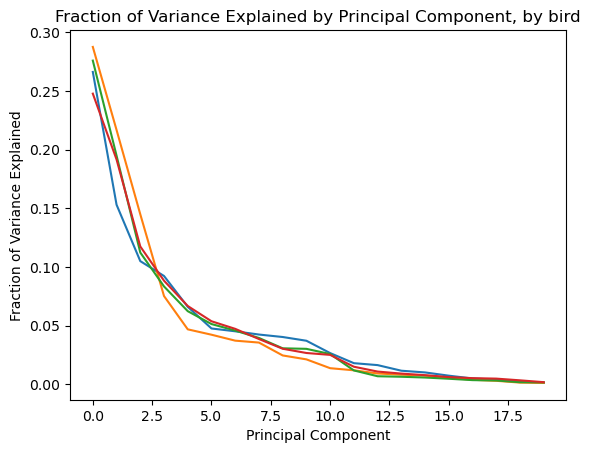

In [16]:
# ok zscore and pca the data and prepare for clustering
# make more dicts for the pca
byBird_pca = dict()
for bird in birds:
    byBird_pca[bird] = byBird[bird].apply(zscore)
    # pca the data and store it in the dictionary
    pca = PCA(n_components=20, svd_solver='full')
    byBird_pca[bird] = pca.fit_transform(byBird_pca[bird])
    print(f'bird = {bird}, shape = {byBird_pca[bird].shape}')
    print(f'explained variance = {pca.explained_variance_ratio_}')
    plt.plot(pca.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Fraction of Variance Explained')
    plt.title('Fraction of Variance Explained by Principal Component, by bird')



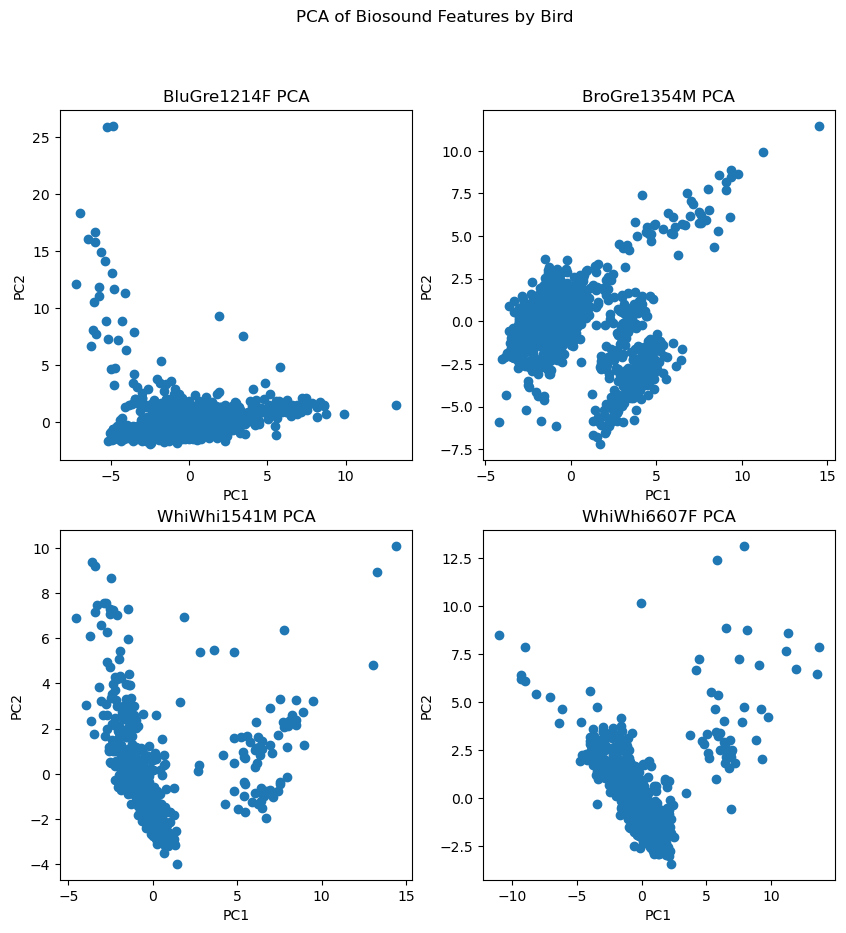

In [17]:
# plot the first two pcas of the data, for each bird, let's do it with subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('PCA of Biosound Features by Bird')
for i, bird in enumerate(birds):
    ax = axs[int(i/2), i%2]
    ax.scatter(byBird_pca[bird][:,0], byBird_pca[bird][:,1])
    ax.set_title(f'{bird} PCA')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

In [18]:
byBird_umap = dict()
for bird in birds:
    byBird_umap[bird] = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean').fit_transform(byBird_pca[bird])
    print(f'bird = {bird}, shape = {byBird_umap[bird].shape}')


bird = BluGre1214F, shape = (1675, 2)
bird = BroGre1354M, shape = (1226, 2)
bird = WhiWhi1541M, shape = (648, 2)
bird = WhiWhi6607F, shape = (791, 2)


bird = BluGre1214F, num clusters = 6
bird = BroGre1354M, num clusters = 4
bird = WhiWhi1541M, num clusters = 6
bird = WhiWhi6607F, num clusters = 6


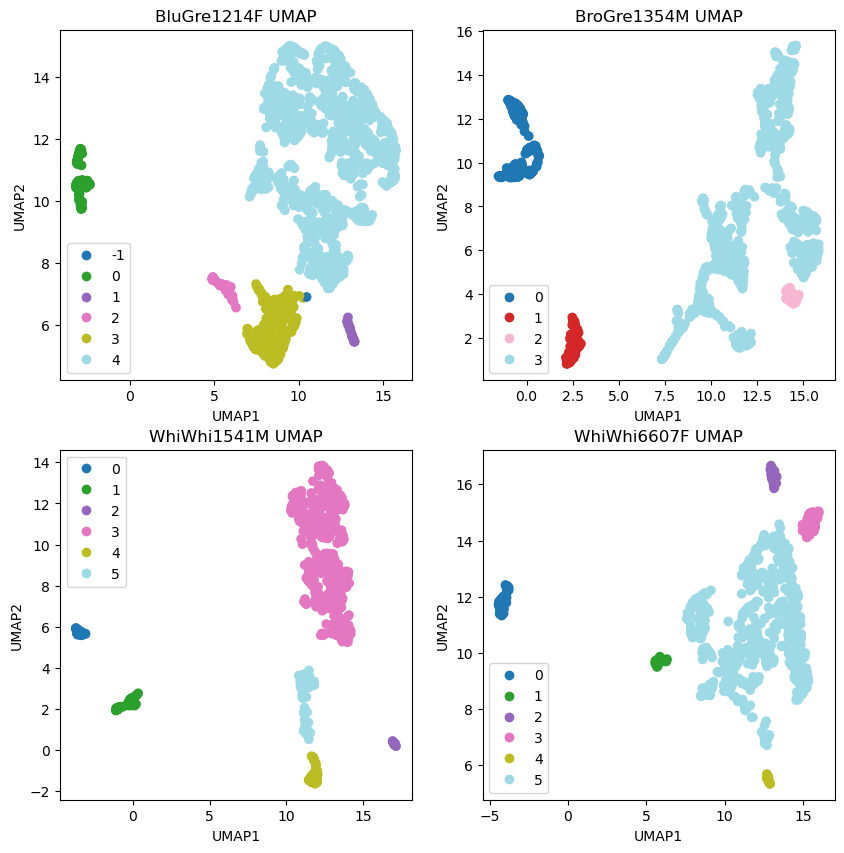

In [19]:
# cluster the umaps with hdbscan
# let's run umaps on the data
min_cluster_size = 10
min_samples = 10
epsilon = 0.8
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=epsilon)

byBird_labels = dict()
for bird in birds:
    clusterer.fit(byBird_umap[bird])
    byBird_labels[bird] = clusterer.labels_
    print(f'bird = {bird}, num clusters = {len(np.unique(byBird_labels[bird]))}')

# plot the umaps with the hdbscan labels
# save the legend for the labels

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i, bird in enumerate(birds):
    ax = axs[int(i/2), i%2]
    labels = np.unique(byBird_labels[bird])
    result = ax.scatter(byBird_umap[bird][:,0], byBird_umap[bird][:,1], label=labels, c=byBird_labels[bird], cmap='tab20')
    ax.set_title(f'{bird} UMAP')
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')
    ax.legend(handles=result.legend_elements()[0],labels=list(labels))




In [20]:
# let's put the labels back into the dataframes
for bird in birds:
    byBird[bird]['labels'] = byBird_labels[bird]



/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_6299/3031293122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  byBird[bird]['labels'] = byBird_labels[bird]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_6299/3031293122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  byBird[bird]['labels'] = byBird_labels[bird]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_6299/3031293122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [29]:
# this is logan's function to make it possible/easy to plot just a spectrogram with biosound

def plot_spectrogram(biosound, DBNOISE=50, f_low=250, f_high=10000, labels=True, title=None):
        sound.spec_colormap()   # defined in sound.py
        cmap = plt.get_cmap('SpectroColorMap')
        
        if biosound.spectro.size != 0 :
            soundSpect = biosound.spectro
            if soundSpect.shape[0] == biosound.to.size:
                soundSpect = np.transpose(soundSpect)
            maxB = soundSpect.max()
            minB = maxB-DBNOISE
            soundSpect[soundSpect < minB] = minB
            minSpect = soundSpect.min()
            # reduce font size in figure

            plt.figure(figsize=(2,2))
            plt.rcParams.update({'font.size': 8})
            plt.imshow(soundSpect, extent = (biosound.to[0]*1000, biosound.to[-1], biosound.fo[0]*1000, biosound.fo[-1]), aspect='auto', interpolation='nearest', origin='lower', cmap=cmap, vmin=minSpect, vmax=maxB)
        if labels:
            plt.ylim(f_low, f_high)
            # plt.xlim(0, t[-1])
            plt.ylabel('Frequency (Hz)')
            plt.xlabel('Time (ms)')
        if title is not None:
            plt.title(title)

bird = BluGre1214F, cluster = -1, num files = 1
bird = BluGre1214F, cluster = 0, num files = 90
bird = BluGre1214F, cluster = 1, num files = 27
bird = BluGre1214F, cluster = 2, num files = 46
bird = BluGre1214F, cluster = 3, num files = 245
bird = BluGre1214F, cluster = 4, num files = 1266
bird = BroGre1354M, cluster = 0, num files = 176
bird = BroGre1354M, cluster = 1, num files = 84
bird = BroGre1354M, cluster = 2, num files = 32
bird = BroGre1354M, cluster = 3, num files = 934
bird = WhiWhi1541M, cluster = 0, num files = 25
bird = WhiWhi1541M, cluster = 1, num files = 45
bird = WhiWhi1541M, cluster = 2, num files = 15
bird = WhiWhi1541M, cluster = 3, num files = 445
bird = WhiWhi1541M, cluster = 4, num files = 43
bird = WhiWhi1541M, cluster = 5, num files = 75
bird = WhiWhi6607F, cluster = 0, num files = 46
bird = WhiWhi6607F, cluster = 1, num files = 26
bird = WhiWhi6607F, cluster = 2, num files = 31
bird = WhiWhi6607F, cluster = 3, num files = 53
bird = WhiWhi6607F, cluster = 4, n

/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_6299/815584446.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(2,2))


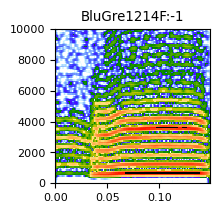

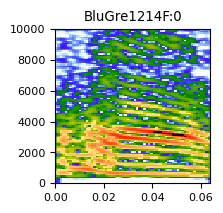

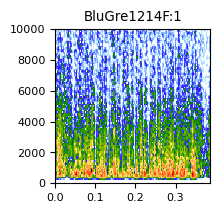

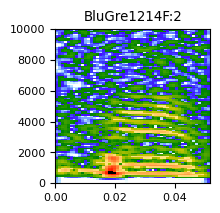

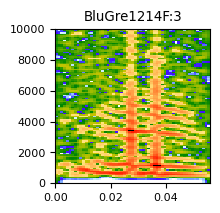

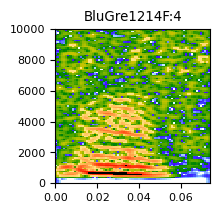

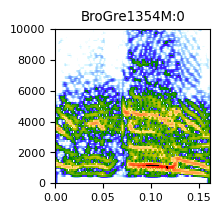

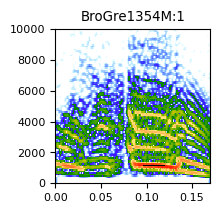

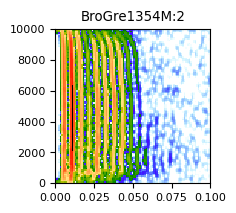

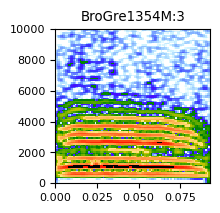

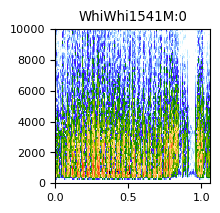

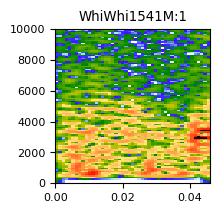

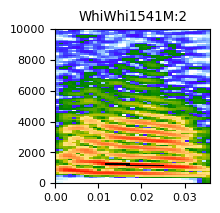

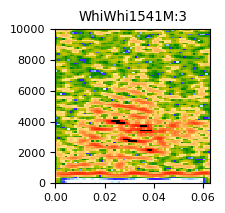

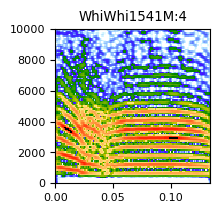

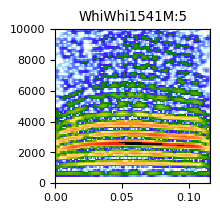

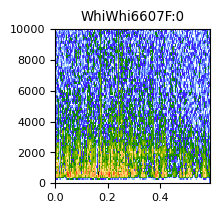

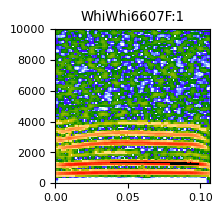

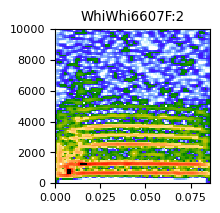

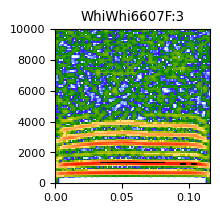

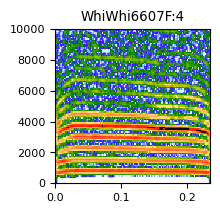

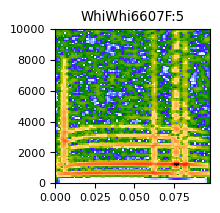

In [33]:
# now let's plot 1 spectrograms from each cluster- let's just do it for one bird
for bird in birds:
# first let's get the file names for each cluster
    cluster_files = dict()
    for cluster in np.unique(byBird_labels[bird]):
        cluster_files[cluster] = files_list[byBird[bird][byBird[bird]['labels'] == cluster].index]

    # now let's plot the spectrograms
    # fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    for i, cluster in enumerate(cluster_files.keys()):
        print(f'bird = {bird}, cluster = {cluster}, num files = {len(cluster_files[cluster])}')
        if len(cluster_files[cluster]) > 1:
            cluster_files[cluster] = cluster_files[cluster][:1]
        for file in cluster_files[cluster]:
            filename = os.path.join(base_folder,'h5filesAmp', file)
            myBioSound = BioSound()
            myBioSound.readh5(filename)
            plot_spectrogram(myBioSound, labels=False,title=f'{bird}:{cluster}')
            # save the figure
            fig_path = os.path.join(base_folder, 'spectrograms', f'bird_{bird}_cluster_{cluster}')
            plt.savefig(fig_path)


bird = BluGre1214F, cluster = -1, num files = 1
bird = BluGre1214F, cluster = 0, num files = 90
bird = BluGre1214F, cluster = 1, num files = 27


/opt/miniconda3/lib/python3.9/site-packages/soundsig/sound.py:541: UserWarning: Trying to register the cmap 'SpectroColorMap' which already exists.
  mpl.colormaps.register(cmap=spec_cmap, force=True)


bird = BluGre1214F, cluster = 2, num files = 46
bird = BluGre1214F, cluster = 3, num files = 245
bird = BluGre1214F, cluster = 4, num files = 1266


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_6299/815584446.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(2,2))


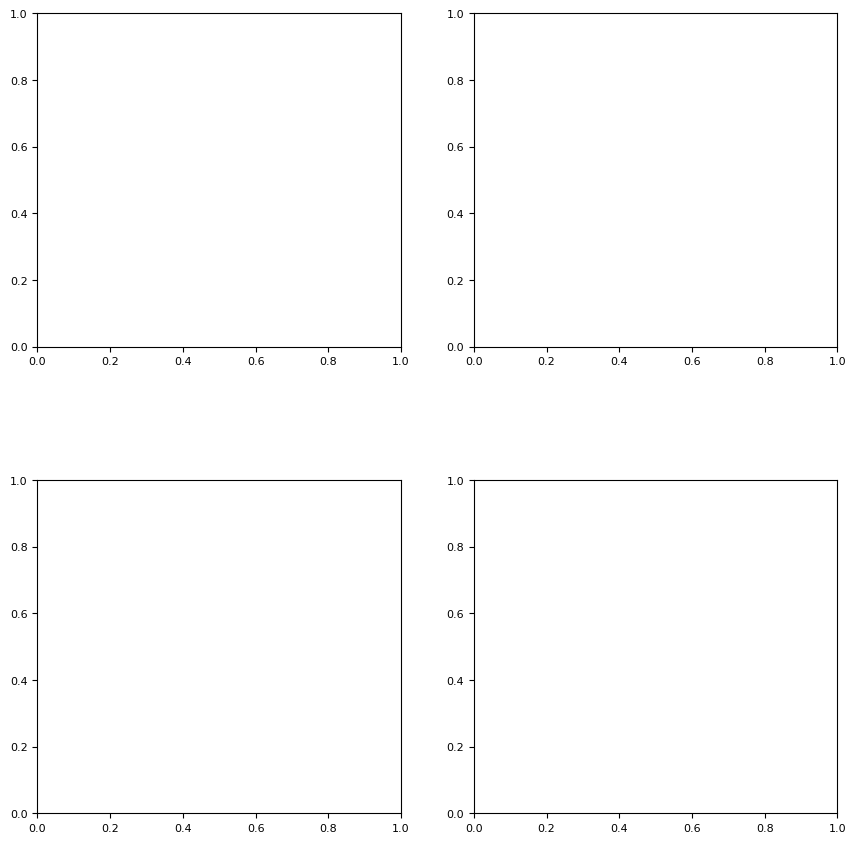

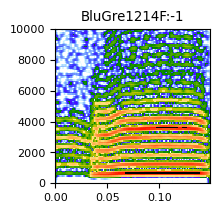

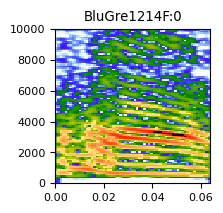

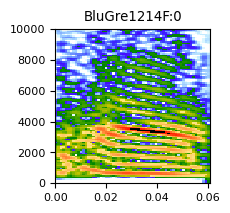

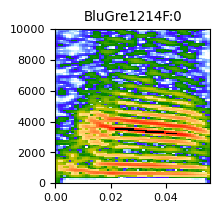

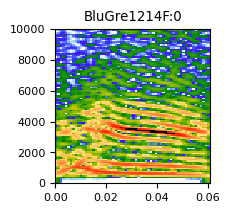

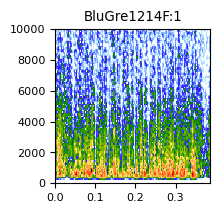

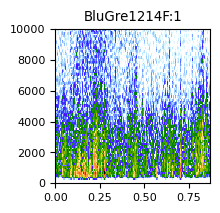

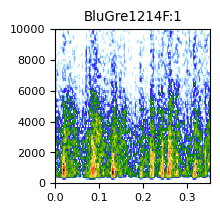

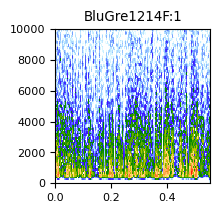

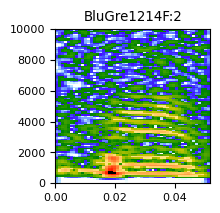

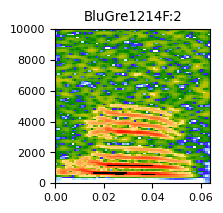

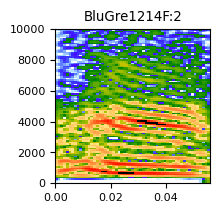

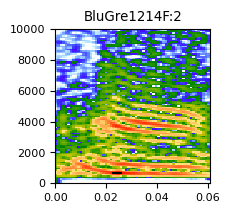

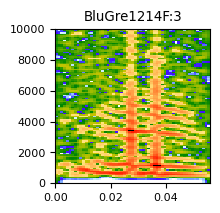

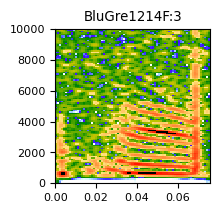

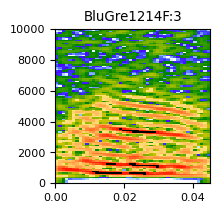

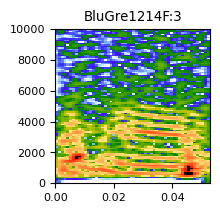

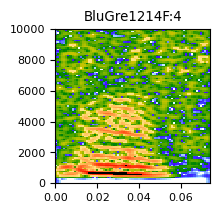

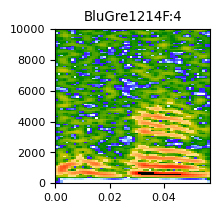

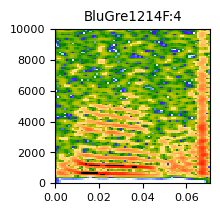

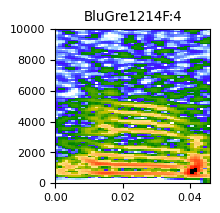

In [36]:
# now let's plot 4 spectrograms from each cluster- let's just do it for one bird
bird = 'BluGre1214F'
# first let's get the file names for each cluster
cluster_files = dict()
for cluster in np.unique(byBird_labels[bird]):
    cluster_files[cluster] = files_list[byBird[bird][byBird[bird]['labels'] == cluster].index]

# now let's plot the spectrograms
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
for i, cluster in enumerate(cluster_files.keys()):
    print(f'bird = {bird}, cluster = {cluster}, num files = {len(cluster_files[cluster])}')
    if len(cluster_files[cluster]) > 4:
        cluster_files[cluster] = cluster_files[cluster][:4]
    else:
        cluster_files[cluster] = cluster_files[cluster][:len(cluster_files[cluster])]
    for file in cluster_files[cluster]:
        filename = os.path.join(base_folder,'h5filesAmp', file)
        myBioSound = BioSound()
        myBioSound.readh5(filename)
        
        plot_spectrogram(myBioSound, labels=False,title=f'{bird}:{cluster}')
        # save the figure
        fig_path = os.path.join(base_folder, 'spectrograms', f'bird_{bird}_cluster_{cluster}')
        plt.savefig(fig_path)

# to plot average spectrograms of all birds 

In [34]:
def cut_spectrograms_to_min_length(cluster_files, base_folder):
    min_lengths = dict()
    for cluster in cluster_files.keys():
        min_length = np.inf
        for file in cluster_files[cluster]:
            filename = os.path.join(base_folder,'h5filesAmp', file)
            myBioSound = BioSound()
            myBioSound.readh5(filename)
            if myBioSound.spectro.shape[1] < min_length:
                min_length = myBioSound.spectro.shape[1]
        min_lengths[cluster] = min_length
    return min_lengths

def get_cluster_spectrograms(cluster_files, min_lengths, base_folder):
    cluster_spectrograms = dict()
    for cluster in cluster_files.keys():
        np_spectrograms = np.zeros((len(cluster_files[cluster]),101, min_lengths[cluster]))
        for i, file in enumerate(cluster_files[cluster]):
            filename = os.path.join(base_folder,'h5filesAmp', file)
            myBioSound = BioSound()
            myBioSound.readh5(filename)
            np_spectrograms[i,:,:] = myBioSound.spectro[:,:min_lengths[cluster]]
        cluster_spectrograms[cluster] = np.mean(np_spectrograms, axis=0)
    return cluster_spectrograms

i=0, cluster=-1, num_rows=3
i=1, cluster=0, num_rows=3
i=2, cluster=1, num_rows=3
i=3, cluster=2, num_rows=3
i=4, cluster=3, num_rows=3
i=5, cluster=4, num_rows=3
i=0, cluster=0, num_rows=2
i=1, cluster=1, num_rows=2
i=2, cluster=2, num_rows=2
i=3, cluster=3, num_rows=2
i=0, cluster=0, num_rows=3
i=1, cluster=1, num_rows=3
i=2, cluster=2, num_rows=3
i=3, cluster=3, num_rows=3
i=4, cluster=4, num_rows=3
i=5, cluster=5, num_rows=3
i=0, cluster=0, num_rows=3
i=1, cluster=1, num_rows=3
i=2, cluster=2, num_rows=3
i=3, cluster=3, num_rows=3
i=4, cluster=4, num_rows=3
i=5, cluster=5, num_rows=3


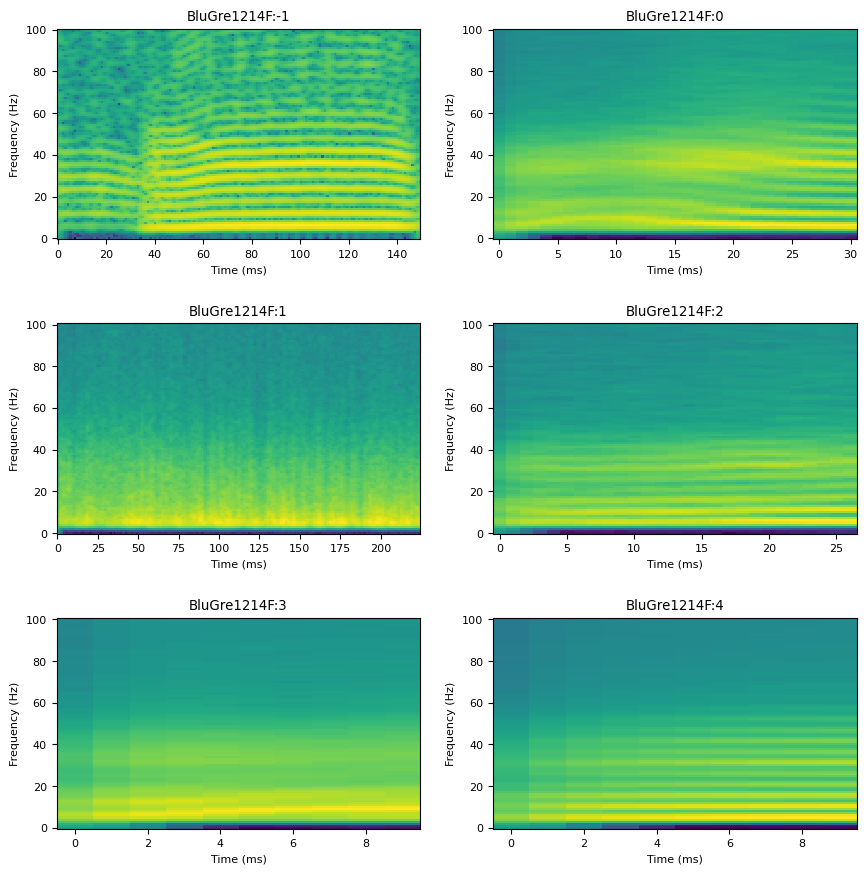

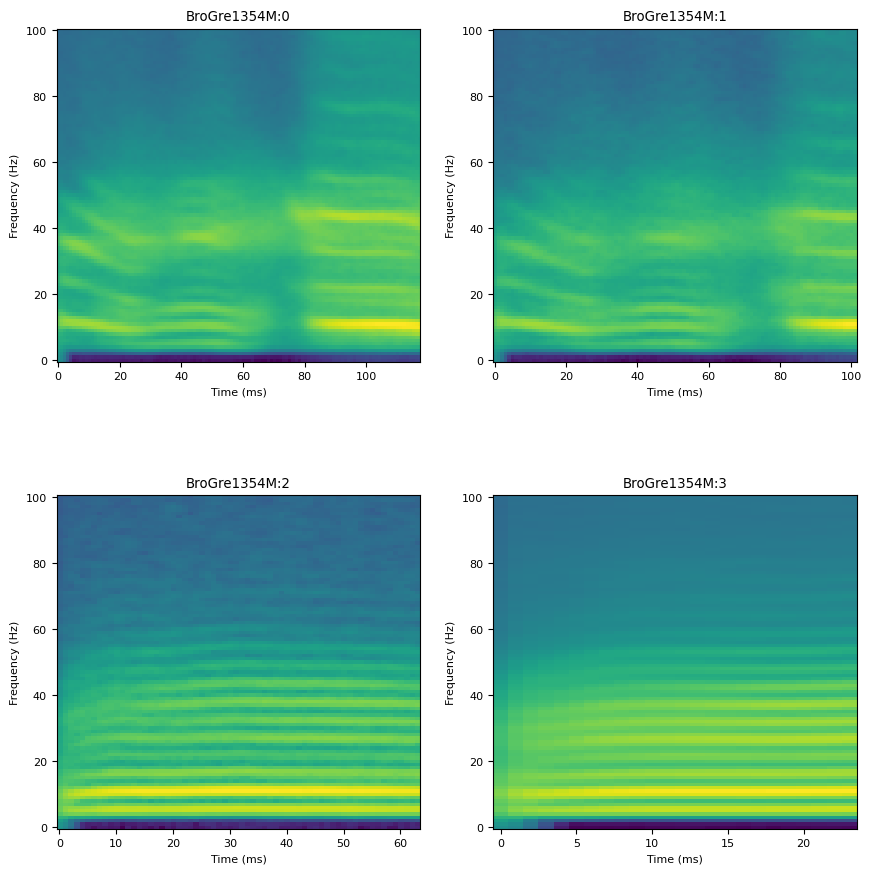

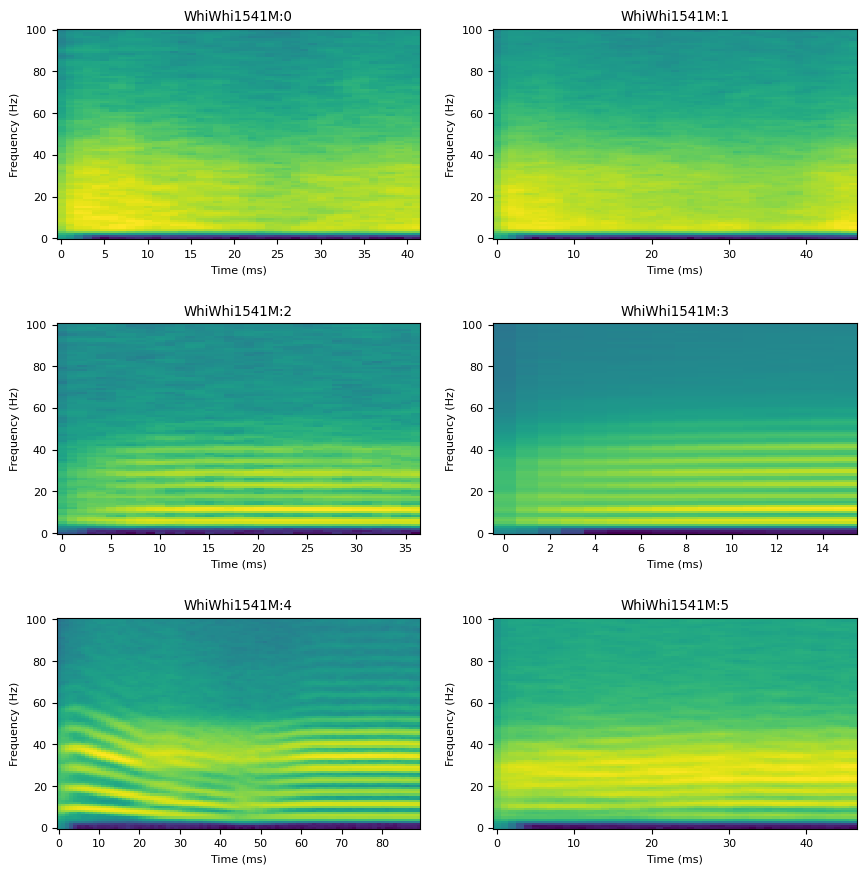

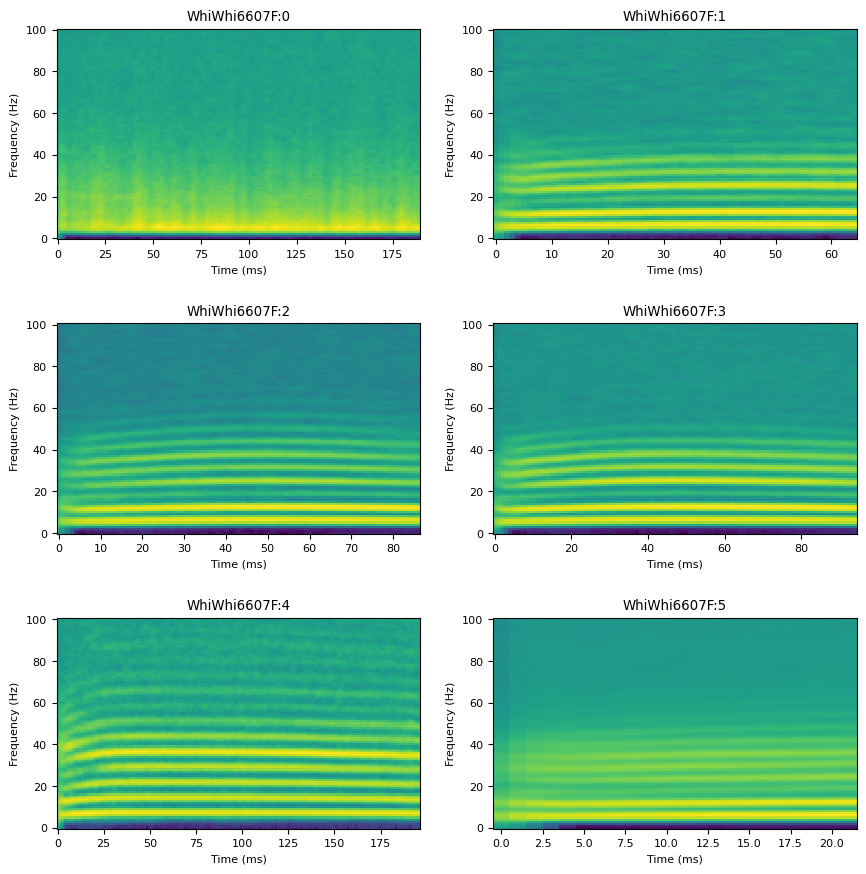

In [35]:
for bird in birds:
    cluster_files = dict()
    for cluster in np.unique(byBird_labels[bird]):
        cluster_files[cluster] = files_list[byBird[bird][byBird[bird]['labels'] == cluster].index]
    min_lengths = cut_spectrograms_to_min_length(cluster_files, base_folder)
    cluster_spectrograms = get_cluster_spectrograms(cluster_files, min_lengths, base_folder)
    num_rows = int(np.ceil(len(cluster_spectrograms.keys())/2))
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 10))
    # space the subplots more so the legends aren't overwriting each other
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2, hspace=0.4)
    for i, cluster in enumerate(cluster_spectrograms.keys()):
        print(f'i={i}, cluster={cluster}, num_rows={num_rows}')
        if num_rows==1:
            ax = axs
        else:
            ax = axs[int(i/2), i%2]
            ax.imshow(cluster_spectrograms[cluster], aspect='auto', interpolation='nearest', origin='lower')
            ax.set_title(f'{bird}:{cluster}')
            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Frequency (Hz)')
    # save the figures
    fig_path = os.path.join(base_folder, 'spectrograms', f'bird_{bird}_avgclusters')
    plt.savefig(fig_path)
    